In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.39,
    amplitude=2.54e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.390e+00   nan                nan nan  False
amplitude 2.540e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 60664 
    Total predicted counts          : 60541.54
    Total off counts                : 101450.00

    Total background counts         : 20290.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 2.9 s, sys: 35.8 ms, total: 2.94 s
Wall time: 2.95 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 60999 
    Total predicted counts          : 60586.34
    Total off counts                : 101674.00

    Total background counts         : 20334.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 60331 
    Total predicted counts          : 60649.94
    Total off counts                : 101992.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_18 

    Total counts                    : 60882 
    Total predicted counts          : 60536.34
    Total off counts                : 101424.00

    Total background counts         : 20284.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_19 

    Total counts                    : 60483 
    Total predicted counts          : 60533.34
    Total off counts                : 101409.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_38 

    Total counts                    : 60834 
    Total predicted counts          : 60568.34
    Total off counts                : 101584.00

    Total background counts         : 20316.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_39 

    Total counts                    : 60904 
    Total predicted counts          : 60639.34
    Total off counts                : 101939.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_59 

    Total counts                    : 60787 
    Total predicted counts          : 60594.14
    Total off counts                : 101713.00

    Total background counts         : 20342.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_60 

    Total counts                    : 60360 
    Total predicted counts          : 60590.94
    Total off counts                : 101697.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_76 

    Total counts                    : 60405 
    Total predicted counts          : 60587.34
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_77 

    Total counts                    : 60226 
    Total predicted counts          : 60537.74
    Total off counts                : 101431.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_95 

    Total counts                    : 60542 
    Total predicted counts          : 60522.74
    Total off counts                : 101356.00

    Total background counts         : 20271.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_96 

    Total counts                    : 60637 
    Total predicted counts          : 60494.34
    Total off counts                : 101214.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_115 

    Total counts                    : 60677 
    Total predicted counts          : 60506.34
    Total off counts                : 101274.00

    Total background counts         : 20254.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_116 

    Total counts                    : 60173 
    Total predicted counts          : 60487.14
    Total off counts                : 101178.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_135 

    Total counts                    : 60651 
    Total predicted counts          : 60488.54
    Total off counts                : 101185.00

    Total background counts         : 20237.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_136 

    Total counts                    : 60210 
    Total predicted counts          : 60587.94
    Total off counts                : 101682.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_156 

    Total counts                    : 60347 
    Total predicted counts          : 60516.54
    Total off counts                : 101325.00

    Total background counts         : 20265.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_157 

    Total counts                    : 60722 
    Total predicted counts          : 60559.34
    Total off counts                : 101539.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_177 

    Total counts                    : 60530 
    Total predicted counts          : 60565.74
    Total off counts                : 101571.00

    Total background counts         : 20314.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_178 

    Total counts                    : 60809 
    Total predicted counts          : 60584.34
    Total off counts                : 101664.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_199 

    Total counts                    : 60718 
    Total predicted counts          : 60751.74
    Total off counts                : 102501.00

    Total background counts         : 20500.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_200 

    Total counts                    : 61223 
    Total predicted counts          : 60495.74
    Total off counts                : 101221.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_220 

    Total counts                    : 60448 
    Total predicted counts          : 60594.94
    Total off counts                : 101717.00

    Total background counts         : 20343.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_221 

    Total counts                    : 60583 
    Total predicted counts          : 60539.74
    Total off counts                : 101441.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_241 

    Total counts                    : 60762 
    Total predicted counts          : 60489.14
    Total off counts                : 101188.00

    Total background counts         : 20237.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_242 

    Total counts                    : 60924 
    Total predicted counts          : 60638.34
    Total off counts                : 101934.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_262 

    Total counts                    : 60676 
    Total predicted counts          : 60584.14
    Total off counts                : 101663.00

    Total background counts         : 20332.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_263 

    Total counts                    : 61016 
    Total predicted counts          : 60450.34
    Total off counts                : 100994.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_282 

    Total counts                    : 60422 
    Total predicted counts          : 60560.54
    Total off counts                : 101545.00

    Total background counts         : 20309.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_283 

    Total counts                    : 60740 
    Total predicted counts          : 60504.54
    Total off counts                : 101265.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_303 

    Total counts                    : 60439 
    Total predicted counts          : 60538.74
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_304 

    Total counts                    : 60877 
    Total predicted counts          : 60515.14
    Total off counts                : 101318.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_323 

    Total counts                    : 60436 
    Total predicted counts          : 60619.54
    Total off counts                : 101840.00

    Total background counts         : 20368.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_324 

    Total counts                    : 59873 
    Total predicted counts          : 60600.14
    Total off counts                : 101743.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_346 

    Total counts                    : 60698 
    Total predicted counts          : 60549.94
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_347 

    Total counts                    : 60732 
    Total predicted counts          : 60627.94
    Total off counts                : 101882.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_367 

    Total counts                    : 60340 
    Total predicted counts          : 60565.34
    Total off counts                : 101569.00

    Total background counts         : 20313.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_368 

    Total counts                    : 60453 
    Total predicted counts          : 60603.54
    Total off counts                : 101760.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_388 

    Total counts                    : 60669 
    Total predicted counts          : 60621.34
    Total off counts                : 101849.00

    Total background counts         : 20369.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_389 

    Total counts                    : 60281 
    Total predicted counts          : 60536.54
    Total off counts                : 101425.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_410 

    Total counts                    : 60679 
    Total predicted counts          : 60636.14
    Total off counts                : 101923.00

    Total background counts         : 20384.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_411 

    Total counts                    : 60882 
    Total predicted counts          : 60689.94
    Total off counts                : 102192.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_429 

    Total counts                    : 60567 
    Total predicted counts          : 60464.54
    Total off counts                : 101065.00

    Total background counts         : 20213.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_430 

    Total counts                    : 60649 
    Total predicted counts          : 60537.94
    Total off counts                : 101432.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_448 

    Total counts                    : 60647 
    Total predicted counts          : 60737.14
    Total off counts                : 102428.00

    Total background counts         : 20485.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_449 

    Total counts                    : 60691 
    Total predicted counts          : 60522.34
    Total off counts                : 101354.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_467 

    Total counts                    : 60224 
    Total predicted counts          : 60662.14
    Total off counts                : 102053.00

    Total background counts         : 20410.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_468 

    Total counts                    : 60378 
    Total predicted counts          : 60580.54
    Total off counts                : 101645.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_484 

    Total counts                    : 60943 
    Total predicted counts          : 60574.74
    Total off counts                : 101616.00

    Total background counts         : 20323.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_485 

    Total counts                    : 60912 
    Total predicted counts          : 60583.74
    Total off counts                : 101661.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_499 

    Total counts                    : 60882 
    Total predicted counts          : 60450.14
    Total off counts                : 100993.00

    Total background counts         : 20198.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



Text(0, 0.5, 'No. of observations')

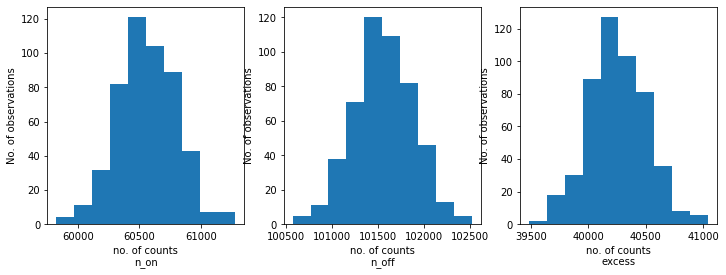

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 1min 29s, sys: 152 ms, total: 1min 29s
Wall time: 1min 30s


In [15]:
results

[{'index': 2.3804404440005125,
  'amplitude': 2.6121479406726047e-12,
  'lambda_': 0.10468602494876034},
 {'index': 2.391292467114229,
  'amplitude': 2.5153909912952153e-12,
  'lambda_': 0.102259922647431},
 {'index': 2.394936108220975,
  'amplitude': 2.5161375849793097e-12,
  'lambda_': 0.1034260809919833},
 {'index': 2.395540313264187,
  'amplitude': 2.5104478174288534e-12,
  'lambda_': 0.09974998586559819},
 {'index': 2.399426228437847,
  'amplitude': 2.5210839977092524e-12,
  'lambda_': 0.10009484872875762},
 {'index': 2.388399796973316,
  'amplitude': 2.527494201174405e-12,
  'lambda_': 0.10441309001485506},
 {'index': 2.402197226146243,
  'amplitude': 2.4949525935607397e-12,
  'lambda_': 0.09122094407348579},
 {'index': 2.3816697479801285,
  'amplitude': 2.573057498275843e-12,
  'lambda_': 0.10876838232276392},
 {'index': 2.3874064376503545,
  'amplitude': 2.548304366556797e-12,
  'lambda_': 0.09969704302110455},
 {'index': 2.3952255913922387,
  'amplitude': 2.492834874642826e-12

index: 2.389922463551723 += 0.007627464257448596


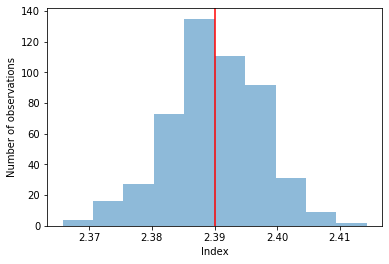

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 2.5410050078950046e-12 += 3.9803379910439626e-14


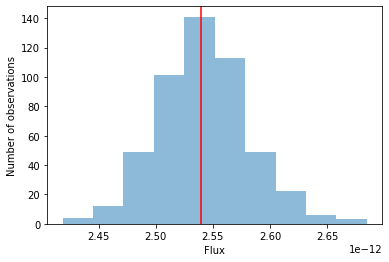

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.10031471177868577 += 0.006863616568688473


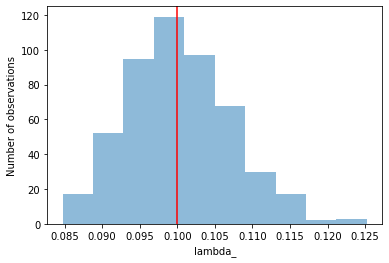

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")